# Lab Session #6
## Computational Neurophysiology [E010620A]
### Dept of Electronics and Informatics (VUB) and Dept of Information Technology (UGent)
Jorne Laton, Matthias Inghels, Talis Vertriest, Jeroen Van Schependom, Sarah Verhulst

<font color=blue>Student names and IDs:</font> Constantijn Coppers (02010771)
<br>
<font color=blue>Academic Year:</font> 2023-2024

<a id="top"></a> 

# Neural Networks


## Aim<a id="introduction"></a>

These exercises make you familiar with neural networks in the field of computational neurophysiology. You will not need to train models yourself, but it is the intention to use an already existing model. You can find more information in the attached paper Drakopoulos et al. (2021) and the Primer paper uploaded to Ufora.


### Case Study : HH model - revisited<a id="CS1"></a>

Deep Learning Hodgkin-Huxley models offer a promising framework for advancing our understanding of neural dynamics, with advantages including increased flexibility, better representation of nonlinear dynamics, improved generalization, integration with large-scale data, enhanced prediction capabilities, and compatibility with modern computational tools. These models revolutionize computational neuroscience research and pave the way for new insights into brain function and dysfunction.

## Q1: Loading the model and the data

Given the code below, install the package keras and load the analytic HH model you programmed in the beginning of the semester again. Add a print statement at the end of your code that tells you how long it took for it to compute the output of the function. We will use the model to check the outcome of our CNN model, and compare the timings later on.

Using keras, load the provided CNN model architecture (Gmodel.json) and the pre-trained weights (Gmodel.h5). This model was trained for you on step functions. What are the dimensions of the input layer? What do these numbers mean?

In [1]:
import keras
import tensorflow as tf
from keras.models import model_from_json

import numpy as np
import math

import matplotlib.pyplot as plt

from HH_model import HH_simulator
from HH_functions import HH

import time

In [2]:
print('keras version:', keras.__version__)
print('tensorflow version:', tf.__version__)

keras version: 2.13.1
tensorflow version: 2.13.0


In [3]:
model1 = "AECNN_2048_VHH_random_context256_646464646464646464_k16_tanh_sigm"
json_file = open("Notebook_4.2_Files/"+model1+"/Gmodel.json", "r")
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
g_opt = keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'mean_absolute_error', optimizer=g_opt)

model.load_weights("Notebook_4.2_Files/"+model1+"/Gmodel.h5")

In [4]:
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bmm_input (InputLayer)      [(None, 2560, 1)]         0         
                                                                 
 model_2 (Functional)        (None, 2048, 1)           1511489   
                                                                 
Total params: 1511489 (5.77 MB)
Trainable params: 1511489 (5.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [5]:
# get the dimensions of the input layer
model_shape = model.input_shape
N_input = model_shape[1]
print(N_input)

2560


<div class="alert alert-success">
<span style="color:black">
 
**A1 conclusion**<a id="A1"></a>   

The input layer dimensions are specified as `(None, 2560, 1)`, where `(20560, 1)` denotes the size of the input image (which is a 1D array in this case; namly the input current). The `None` dimension indicates the model's capability to process variable batch sizes. The output dimensions are `(None, 2048, 1)` and equivalently defined as the input.

</span>

## Q2: Create a stimulus

Create an input for the HH models. The sampling rate is 20 kHz, with this you should be able to derive what the length of the stimulus should be to match the input length of the stimulus in the CNN HH model. Make sure that your stimulus starts with 17.8 ms of silence, and after this make the voltage jump to 20 (mV). Plot the stimulus and the output of the analytic HH model.

* (a) Is the output of the analytic model what you expect?

* (b) What is the amplitude of the generated spikes?

* (c) How long did it take to compute this?

In [6]:
# sampling frequency
fs = 20  # kHz

# Step function
tau = 17.8 
I_step_input = lambda t: np.heaviside(t - tau, 1.0) * 20

# define HH model
# HH_obj = HH_simulator()
# HH = HH_obj.simulate
# t, V = HH(I_step_input, N_input, fs, print_sim_time = True)

In [7]:
# Run the model twice
t, V = HH(I_step_input, N_input, 1 / fs, print_sim_time = True)
t, V = HH(I_step_input, N_input, 1 / fs, print_sim_time = True)

Simulation Time: 203.863 ms
Simulation Time: 113.818 ms


In [8]:
# get the amplitudes
from scipy.signal import find_peaks
peak_ind = find_peaks(V,  height = 0, width = 10)[0]

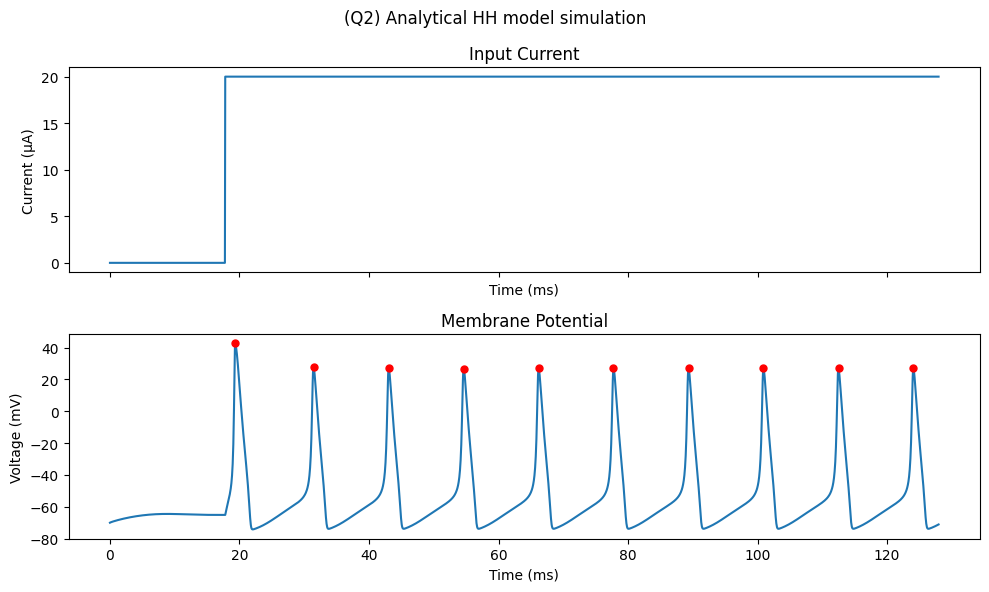

In [9]:
# make a plot of the simualtion
n_rows, n_cols = 2, 1
fig, (ax1, ax2) = plt.subplots(n_rows, n_cols, figsize = (10*n_cols, 3*n_rows), sharex = True)

plt.suptitle('(Q2) Analytical HH model simulation')

ax1.plot(t, I_step_input(t))
ax1.set_title('Input Current')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Current (µA)')


ax2.plot(t, V)
ax2.plot(t[peak_ind], V[peak_ind], marker = 'o', ls = '', color = 'red', markersize = 5)
ax2.set_title('Membrane Potential')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Voltage (mV)')

plt.tight_layout()
plt.show()

In [10]:
print(V[peak_ind])

[42.69361966 27.85626761 27.0801995  26.81374039 26.98449291 26.85238875
 26.97170415 26.89795837 26.95268803 26.93381838]


<div class="alert alert-success">
<span style="color:black">
    
**A2 conclusion** 

- The simulated membrane voltage aligns with expectations, exhibiting characteristic stages of the action potential: resting state, depolarization, repolarization, and hyperpolarization.

- The initial spike amplitude measures about 42.7 mV, while subsequent spikes average approximately 26.9 - 27 mV in amplitude.

- The computational process consumed approximately 48.5 ms; however, this duration may vary from computer-to-computer.

</span>

## Q3: Plot the output of the Deep CNN HH model

Using the same stimulus as in Q2, plot the output of the CNN HH model. Make sure to reshape the stimulus to the appropriate input shape you found in Q1, and multiply the stimulus by a scaling factor of 1e-3 before you put it in the model. Divide the output of the model by a factor of 1e-2 and plot it together with the output of the analytic model. These normalization scaling factors are crucial to any kind of deep learning models. The way they are proposed here, as in the paper of Drakopoulos et al., is to normalize the inputs and scale the result back to mV. You will also need to crop the analytic HH model to plot them together, check the shape of the output of the CNN HH model. Crop the analytic HH model the same length at both sides.

* (a) How well do the CNN and the analytic model line up? Can you think of a reason why it is particularly good or bad?

* (b) Why would the model cut the edges?

* (c) How do the timings to calculate the output compare between the two models? Why?

* (d) In the paper attached to module 4 of this course, what are the advantages of using formulas 1-13 compared to the HH model of module 1? What is possible with the deep learning architecture that is not with the simplest HH model? What is the most correct model with respect to the biophysical system? HINT: think about how these models are fitted

In [11]:
# Simulate by CNN 
# scaled stimulus
input_cnn = I_step_input(t).reshape((-1, N_input, 1)) * 1e-3  

# Pass the stimulus through the CNN HH model
output_cnn = model.predict(input_cnn).reshape(-1) / 1e-2

# run model twice
output_cnn = model.predict(input_cnn).reshape(-1) / 1e-2

# get appropriate time vector
t_cnn = np.arange(output_cnn.shape[0]) / fs

1/1 [==============================] - 0s 57ms/step


In [12]:
peaks_cnn = find_peaks(-output_cnn)[0]
i_start_cnn = peaks_cnn[27]
i_start_HH = 357
i_crop = i_start_HH - i_start_cnn - 5

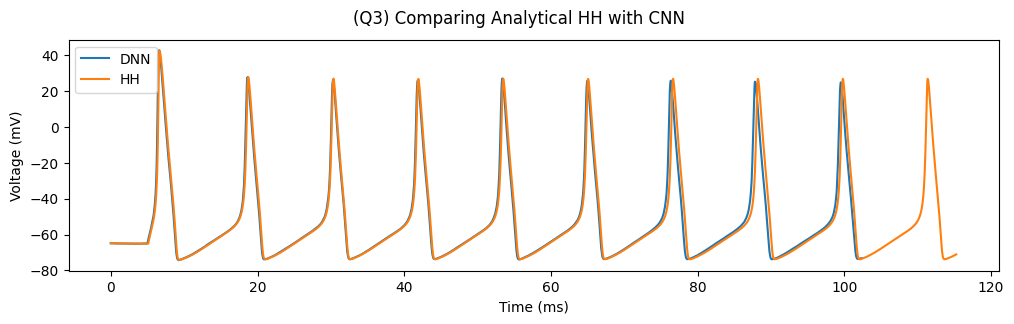

In [13]:
# make a plot of the simualtion
n_rows, n_cols = 1, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize = (12*n_cols, 3*n_rows), sharex = True)

plt.suptitle('(Q3) Comparing Analytical HH with CNN')


ax.plot(t_cnn, output_cnn, label = 'DNN')
ax.plot(t[i_crop:] - t[i_crop], V[i_crop:], label = 'HH')

# ax.set_title('Membrane Potential')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.legend()

plt.show()

<div class="alert alert-success">
<span style="color:black">
    
**A3 conclusion**<a id="A3"></a>   

- Overall, the alignment between the HH simulation and the DNN simulation appears to be satisfactory initially, but deteriorates over time. This decline in alignment could be attributed to the fact that the DNN model is primarily trained on step currents with amplitudes ranging up to 1000 µA. Consequently, the DNN model performs well when presented with inputs within this range due to its familiarity with such patterns (i.e. the data is seen). 

- Upon closer examination of the CoNNear architecture, it becomes evident that a final cropping layer is incorporated to remove context from the image. However, context is crucial for ensuring continuous boundaries and considering neuronal adaptation processes, as stated in Drakopoulos et al.

- The simulation conducted by the CoNNear network outpaces that of the HH model simulation$^1$. In simple terms, this can be attributed to the DNN's reliance on simpler calculations (matrix calculations) compared to the HH model, which involves iterations and computationally (more) intensive functions such as `np.exp()`, `np.power()` etc.

- The primary advantage of employing formulas 1-13 from Yang et al. lies in their simplicity compared to the HH model, which comprises coupled nonlinear differential equations, resulting in faster computation. Additionally, DNNs offer several benefits:
  - Accurate representation of complex mathematical descriptions.
  - Reduced computational time and complexity.
  - Differentiable nature, facilitating backpropagation algorithms for training new neuronal networks.

  Nonetheless, the HH model remains the most accurate representation of the biophysical system. The HH model, based on biophysical principles and its parameters fitted to empirical data, effectively captures the dynamics of ion channels and membrane potentials in neurons. In contrast, DNNs have a predictive nature, focusing on forecasting neuronal spiking based on extensive prior data rather than optimizing physiological parameters.

$^1$The model is run twice as the initial run takes longer due to data fetching from memory. Comparatively, the HH model tends to be faster in the first run as it requires less memory data, reflecting its relatively 'simpler' nature.
</span>

## Q4: Sine stimulus

Construct a sine stimulus with frequency $f_{sine}$ and amplitude 80 (mV). The sampling rate is still 20 kHz and in front of the stimulus is still 17.8 ms silence. Find the minimal $f_{sine}$ for which the (a) analytic HH model and (b) CNN HH model spike. 

* (c) Do these values match up?

* (d) For a sinusoidal stimulus, is the deep learning model as accurate as with a step function? Why?

In [14]:
def plot_input(ax, t, f, title = ''):
    
    ax.plot(t , I_sine(t, f))
    
    ax.set_title(title)
    ax.set_ylabel('Current (µA)')
    ax.set_xlabel('Time (ms)')

In [15]:
def get_cnn_sim(I_input):

    # reshape the input vector
    input_cnn = I_input.reshape((-1, N_input, 1)) * 1e-3  

    # Pass the stimulus through the CNN HH model
    output_cnn = model.predict(input_cnn).reshape(-1) / 1e-2

    # get appropriate time vector
    t_cnn = np.arange(output_cnn.shape[0]) / fs
    
    return t_cnn, output_cnn

In [16]:
# get the sine stimulus function
tau = 18.7
I_sine = lambda t, f: 80 * np.heaviside(t - tau, 1.0) * np.sin(2*np.pi*f*(t-tau))

# simulation time
t_sim = np.arange(N_input) / fs

# get some frequencies
freqs = [2, 1.5, 1.1, 1, 0.8, 0.12, 0.1001, 0.095, 1e-3, 0]

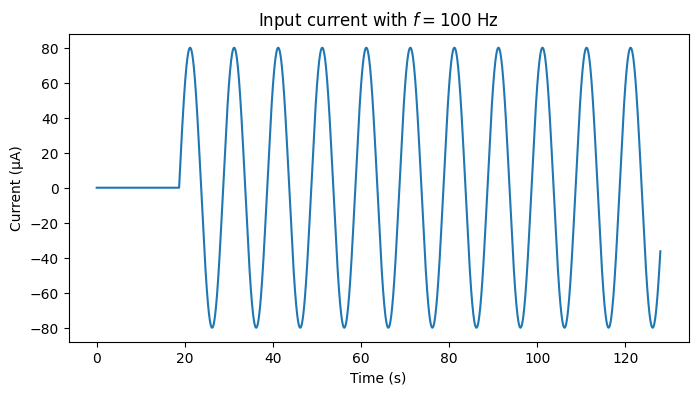

In [17]:
plt.figure(figsize = (8, 4))

plt.title('Input current with $f=100$ Hz')
plt.plot(t_sim, I_sine(t, 0.1))

plt.ylabel('Current (µA)')
plt.xlabel('Time (s)')

plt.show()

In [18]:
# Analysis with odeint solver
from HH_model import HH_simulator
HH2 = HH_simulator().simulate
HH_sims_odeint = {f : HH2(lambda t: I_sine(t, f), N_input, fs, print_sim_time = True) for f in freqs}

Simulation Time: 583.931 ms
Simulation Time: 680.444 ms
Simulation Time: 606.776 ms
Simulation Time: 632.635 ms
Simulation Time: 710.227 ms
Simulation Time: 581.794 ms
Simulation Time: 780.362 ms
Simulation Time: 661.377 ms
Simulation Time: 413.994 ms
Simulation Time: 32.001 ms


In [19]:
# Analysis with function of M. Kramer
HH_sims = {f : HH(lambda t: I_sine(t_sim, f), N_input, 1 / fs , print_sim_time = True) for f in freqs}

Simulation Time: 133.876 ms
Simulation Time: 113.580 ms
Simulation Time: 99.918 ms
Simulation Time: 90.901 ms
Simulation Time: 109.169 ms
Simulation Time: 140.549 ms
Simulation Time: 142.490 ms


C:\Users\coppe\Documents\NN\HH_functions.py:66: RuntimeWarning: overflow encountered in power
  V[i+1] = V[i] + dt*(gNa0*np.power(m[i], 3)*h[i]*(ENa-(V[i]+65)) + gK0*np.power(n[i], 4)*(EK-(V[i]+65)) + gL0*(EL-(V[i]+65)) + I0[i])
C:\Users\coppe\Documents\NN\HH_functions.py:66: RuntimeWarning: invalid value encountered in scalar add
  V[i+1] = V[i] + dt*(gNa0*np.power(m[i], 3)*h[i]*(ENa-(V[i]+65)) + gK0*np.power(n[i], 4)*(EK-(V[i]+65)) + gL0*(EL-(V[i]+65)) + I0[i])
C:\Users\coppe\Documents\NN\HH_functions.py:9: RuntimeWarning: overflow encountered in expm1
  return (2.5 - 0.1*(V+65)) / (np.exp(2.5-0.1*(V + 65)) - 1) if not expm1 else (2.5 - 0.1*(V + 65)) / (np.expm1(2.5 - 0.1*(V + 65)))
C:\Users\coppe\Documents\NN\HH_functions.py:14: RuntimeWarning: overflow encountered in exp
  return 4*np.exp(-(V+65)/18)
C:\Users\coppe\Documents\NN\HH_functions.py:19: RuntimeWarning: overflow encountered in exp
  return 0.07*np.exp(-(V+65)/20)
C:\Users\coppe\Documents\NN\HH_functions.py:24: RuntimeWarn

Simulation Time: 129.132 ms
Simulation Time: 161.464 ms
Simulation Time: 137.087 ms


In [20]:
# simulate by CNN 
CNN_sims = {f : get_cnn_sim(I_sine(t_sim, f)) for f in freqs}

1/1 [==============================] - 0s 59ms/step


In [21]:
def plot_sim(ax, t, V, title = ''):
    
    ax.plot(t[0], V[0], label = 'DNN')
    ax.plot(t[1][i_crop:] - t[1][i_crop] , V[1][i_crop:], label = 'HH (M. Kramer)')
    ax.plot(t[2][i_crop:] - t[2][i_crop] , V[2][i_crop:], ls = '--', label = 'HH (odeint)')

    ax.set_ylim((-120, 55))
    ax.set_title(title)
    ax.set_ylabel('Voltage (mV)')
    ax.set_xlabel('Time (ms)')
    ax.legend()

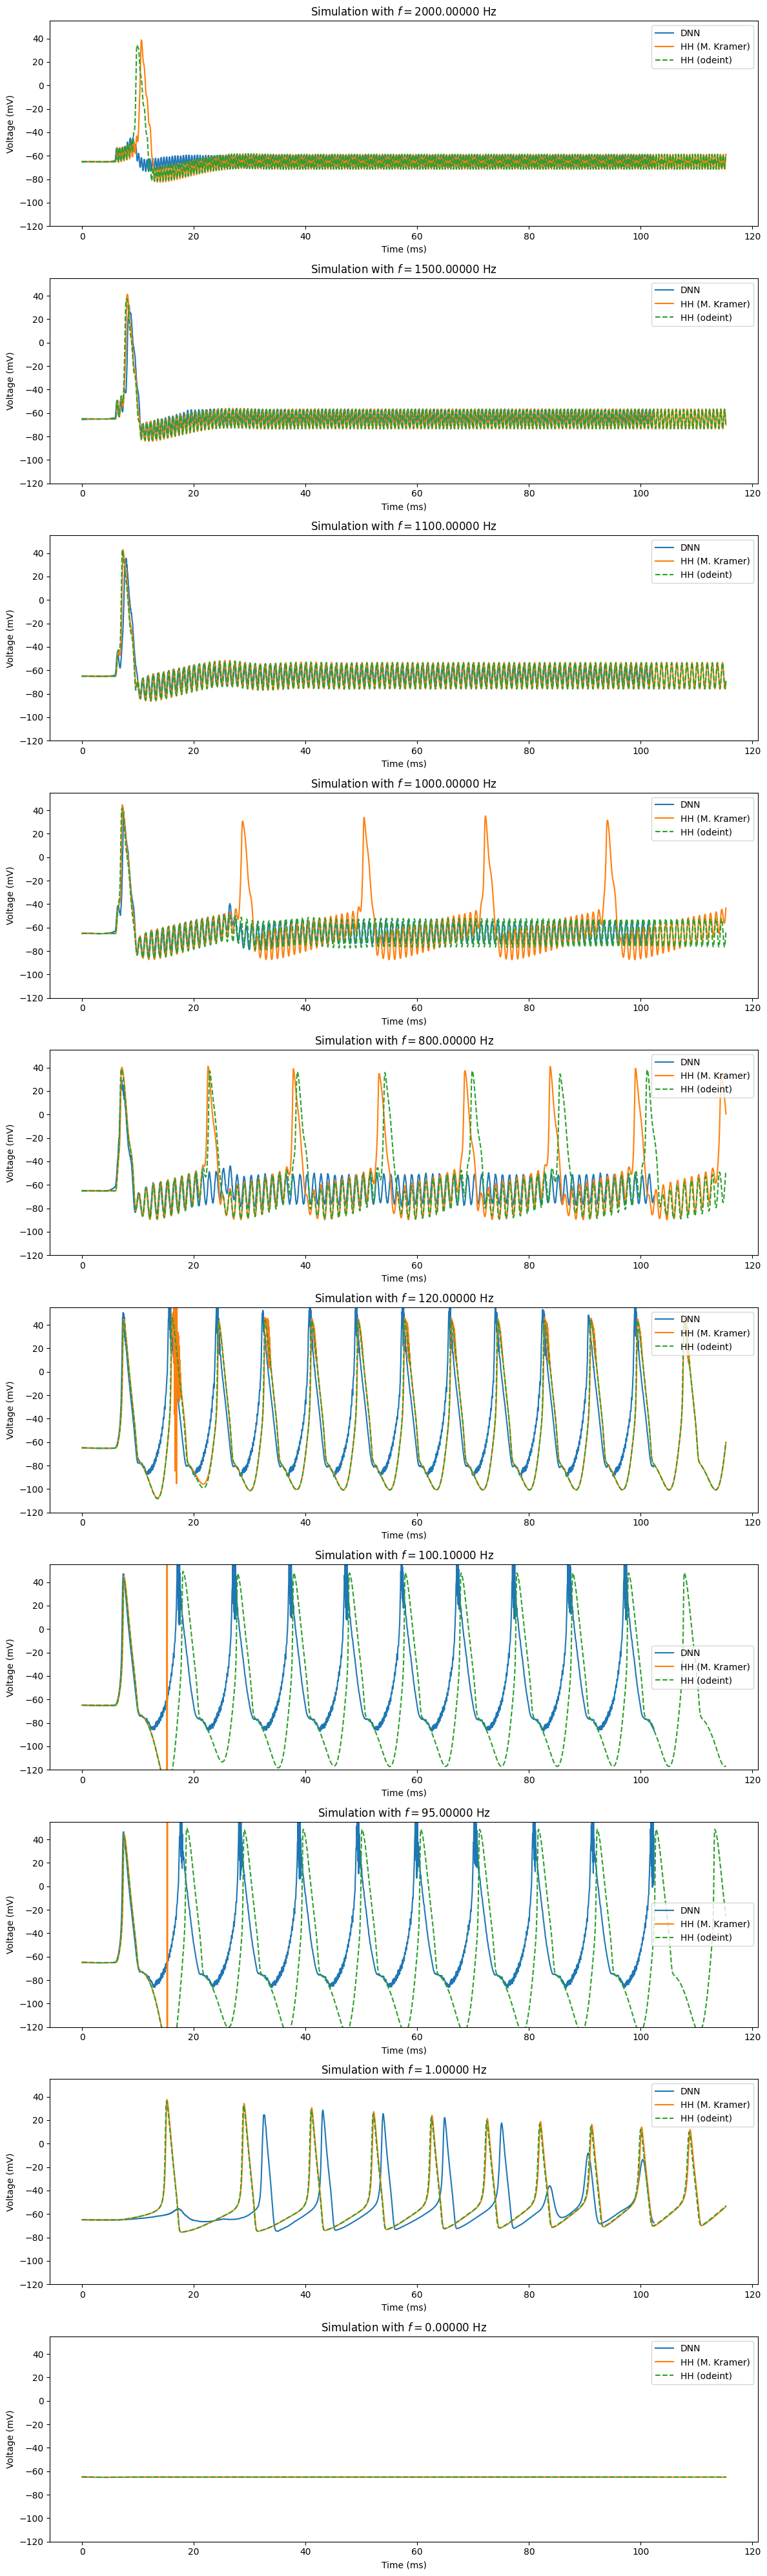

In [22]:
# make plots
n_rows, n_cols = len(freqs), 1
fig, ax = plt.subplots(n_rows, n_cols, figsize = (12*n_cols, 4*n_rows))

for i, f in enumerate(freqs):
    t_cnn, V_cnn = CNN_sims[f]
    t_HH, V_HH = HH_sims[f]
    t_odeint, V_odeint = HH_sims_odeint[f]
    plot_sim(ax[i], (t_cnn, t_HH, t_odeint), (V_cnn, V_HH, V_odeint), title = f'Simulation with $f={f*1e3:.5f}$ Hz')
    # plot_input(ax[i, 0], t, f, title = f'Input Current $f={f*1e3:.5f}$ Hz')
        
plt.tight_layout()
plt.show()

<div class="alert alert-success">
<span style="color:black">
    
**A4 conclusion** 

One can notice that the maximal frequency at which no spiking occurs for both simulations is $\sim 1$ kHz (a bit higher than 1.1 kHz). However, this only relates to the first spike being generated. Investigtion of the plots with a sinusoidal input of e.g. 800 Hz, one observes repetitive spiking in the HH model, while only the first spike is being generated in the DNN model simulation.

Moreover, while the DNN model exhibits similar overall behavior to the HH model with sinusoidal input currents, there are notable differences in spike generation. Although both models display the same oscillatory frequency in the membrane voltage, the manner in which integration and firing occur differs. E.g. in the case of a frequency of 800 Hz, in the HH model, the membrane voltage demonstrates oscillatory behavior during integration, with linear integration superimposed. However, in that same case the DNN model exhibits bounded oscillatory behavior without subsequent spiking. Consequently, the accuracy of the DNN model for sinusoidal stimuli is inferior to that of the HH model.

However, when trying to simulate an input sine with frequencies about 100 Hz by an edited verison of the M. Kramer HH function (the same function used in Drakopoulos et al.), I get an overflow error; the simulation (Euler Method) is not stable and thus I have made a new function that simulats the HH model based on more accurate and numerically stable solvers (`scipy.odeint`). Using this function, I am able to simulate frequencies about 100 Hz, but there still occurs spiking; no minimal frequency is obtained. Even at $f=1$ Hz, all the simulations (HH by M. Kramer, HH by `odeint` and DNN simulation) show (repetitive) spiking  with some degree of alignment between the HH models and the DNN (see last plot above). So one could argue that the minimal frequency is 0, but this situation leads to a trivial case with a zero input; 
$$
I(t) = \sin(2\pi f t) = \sin(0) = 0.
$$

In conclusion, the overal alignment of the DNN with the HH model is worse than in [Q3](#Q3). The result of this might stem from the fact that the DNN is not trained with oscillatority input currents, making it difficult to predict how a neuron exactly behaves on it. However, the overall performance of the DNN is relatively okay.

**Note:** $\sim 1$ kHz means *in the oreder of* 1 kHz.
</span>

## Q5: White noise

Create a new stimulus, again with the same sampling rate and amount of silence in the beginning. Now use white noise with an amplitude of 20 (mV) as stimulus.

* (a) How well do the analytic and the CNN HH model outputs match up?

* (b) Iterate this experiment 100 times, and plot the amount of spikes in a histogram for both models. What do you see and why do you think that is?

In [23]:
# stimulus with white noise
I_wn = lambda t: np.random.normal(0, 1, N_input) * 20 * np.heaviside(t - tau, 1.0)

In [24]:
# simulate the model
t_wn, V_wn = HH(I_wn, N_input, 1/fs, print_sim_time = True)
t_cnn_wn, V_cnn_wn = get_cnn_sim(I_wn(t_wn))

Simulation Time: 73.601 ms
1/1 [==============================] - 0s 92ms/step


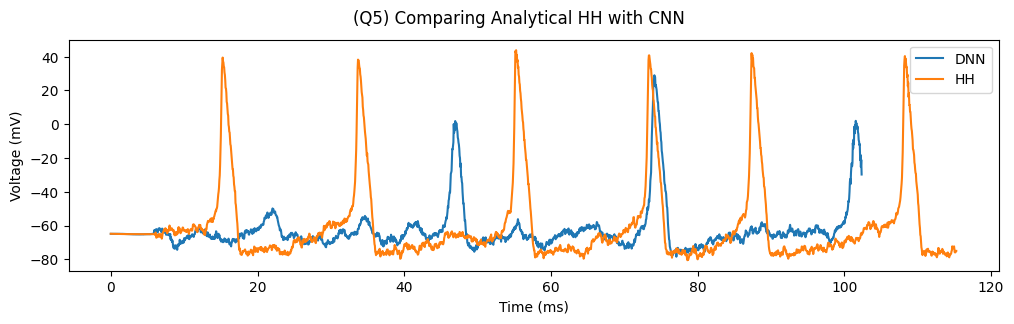

In [25]:
# make a plot of the simualtion
n_rows, n_cols = 1, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize = (12*n_cols, 3*n_rows), sharex = True)

plt.suptitle('(Q5) Comparing Analytical HH with CNN')

ax.plot(t_cnn_wn, V_cnn_wn, label = 'DNN')

ax.plot(t_wn[i_crop:] - t_wn[i_crop], V_wn[i_crop:], label = 'HH')
# ax.plot(t_crop[pks_HH], V_crop[pks_HH], ls = '', marker = 'o', markersize = 2, color = 'red')
# ax.set_title('Membrane Potential')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.legend()

plt.show()

In [26]:
spikes_HH = []
spikes_DNN = []

Simulation Time: 121.880 ms
1/1 [==============================] - 0s 70ms/step
End of Computational Experiment 1
----------------------------------------------------------------------------------------------------

Simulation Time: 142.025 ms
1/1 [==============================] - 0s 74ms/step
End of Computational Experiment 2
----------------------------------------------------------------------------------------------------

Simulation Time: 88.553 ms
1/1 [==============================] - 0s 59ms/step
End of Computational Experiment 3
----------------------------------------------------------------------------------------------------

Simulation Time: 107.343 ms
1/1 [==============================] - 0s 59ms/step
End of Computational Experiment 4
----------------------------------------------------------------------------------------------------

Simulation Time: 88.530 ms
1/1 [==============================] - 0s 56ms/step
End of Computational Experiment 5
------------------------

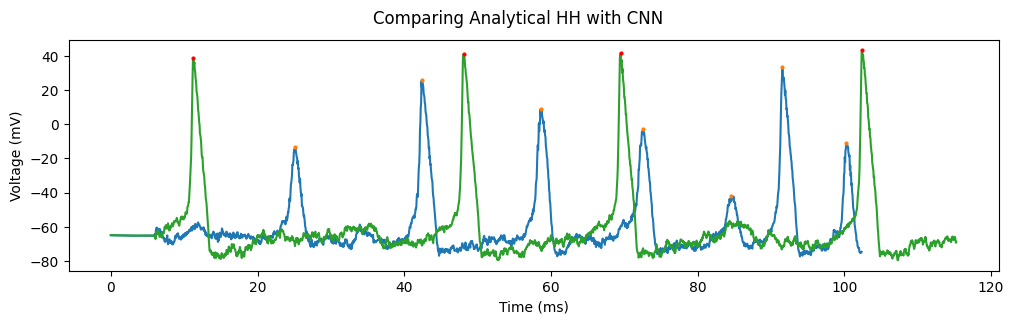

Simulation Time: 107.208 ms
1/1 [==============================] - 0s 69ms/step
End of Computational Experiment 38
----------------------------------------------------------------------------------------------------

Simulation Time: 129.601 ms
1/1 [==============================] - 0s 57ms/step
End of Computational Experiment 39
----------------------------------------------------------------------------------------------------

Simulation Time: 97.514 ms
1/1 [==============================] - 0s 91ms/step
End of Computational Experiment 40
----------------------------------------------------------------------------------------------------

Simulation Time: 168.760 ms
1/1 [==============================] - 0s 55ms/step
End of Computational Experiment 41
----------------------------------------------------------------------------------------------------

Simulation Time: 124.948 ms
1/1 [==============================] - 0s 55ms/step
End of Computational Experiment 42
------------------

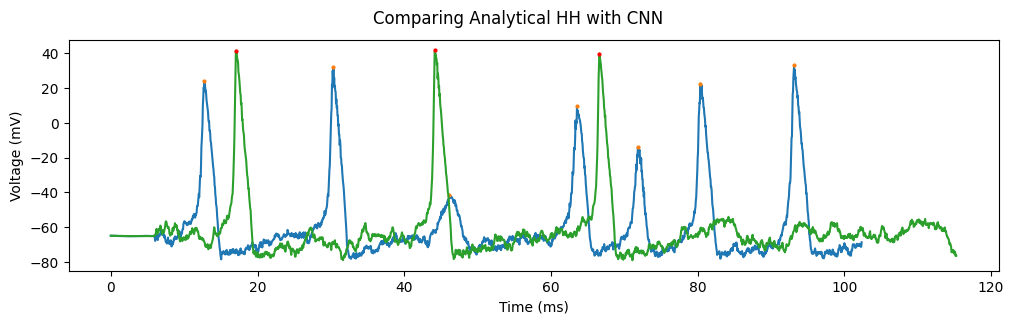

Simulation Time: 126.277 ms
1/1 [==============================] - 0s 69ms/step
End of Computational Experiment 55
----------------------------------------------------------------------------------------------------

Simulation Time: 156.438 ms
1/1 [==============================] - 0s 55ms/step
End of Computational Experiment 56
----------------------------------------------------------------------------------------------------

Simulation Time: 145.458 ms
1/1 [==============================] - 0s 90ms/step
End of Computational Experiment 57
----------------------------------------------------------------------------------------------------

Simulation Time: 170.228 ms
1/1 [==============================] - 0s 92ms/step
End of Computational Experiment 58
----------------------------------------------------------------------------------------------------

Simulation Time: 152.942 ms
1/1 [==============================] - 0s 57ms/step
End of Computational Experiment 59
-----------------

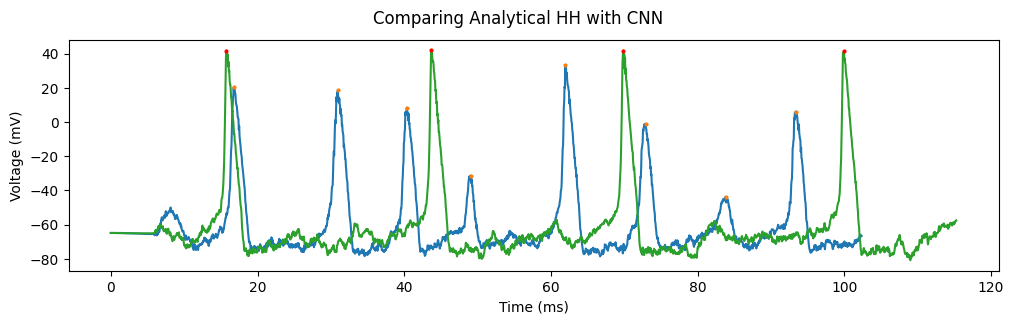

Simulation Time: 99.236 ms
1/1 [==============================] - 0s 58ms/step
End of Computational Experiment 64
----------------------------------------------------------------------------------------------------



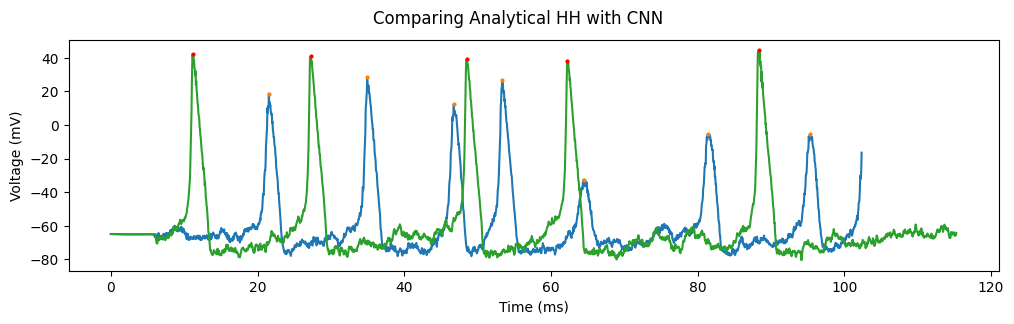

Simulation Time: 134.940 ms
1/1 [==============================] - 0s 50ms/step
End of Computational Experiment 65
----------------------------------------------------------------------------------------------------



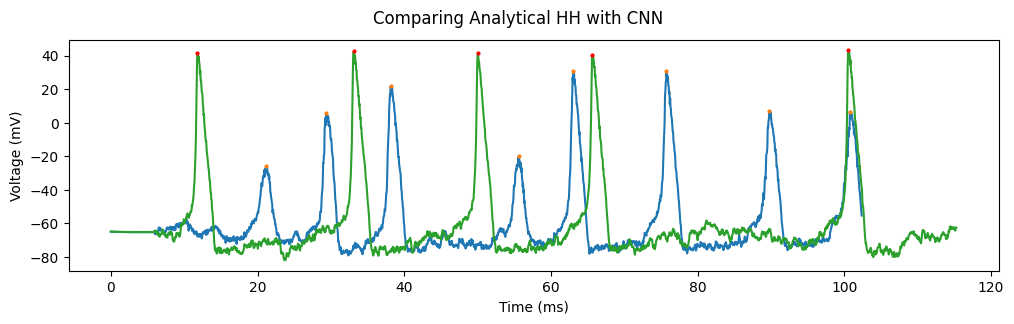

Simulation Time: 119.371 ms
1/1 [==============================] - 0s 66ms/step
End of Computational Experiment 66
----------------------------------------------------------------------------------------------------

Simulation Time: 162.209 ms
1/1 [==============================] - 0s 85ms/step
End of Computational Experiment 67
----------------------------------------------------------------------------------------------------

Simulation Time: 120.680 ms
1/1 [==============================] - 0s 65ms/step
End of Computational Experiment 68
----------------------------------------------------------------------------------------------------

Simulation Time: 97.625 ms
1/1 [==============================] - 0s 79ms/step
End of Computational Experiment 69
----------------------------------------------------------------------------------------------------

Simulation Time: 130.745 ms
1/1 [==============================] - 0s 73ms/step
End of Computational Experiment 70
------------------

In [27]:
# simulate 100 times
N_sim = 100
print_res = False
n_spikes = {'HH': [], 'DNN': []}

i = 0
while i < 100:
    I_wn = lambda t: np.random.normal(0, 1, N_input) * 20 * np.heaviside(t - tau, 1.0)
    t_wn, V_wn = HH(I_wn, N_input, 1/fs, print_sim_time = True)
    t_cnn_wn, V_cnn_wn = get_cnn_sim(I_wn(t_wn))

    t_crop, V_crop = t_wn[i_crop:] - t_wn[i_crop],  V_wn[i_crop:]
    
    pks_cnn = find_peaks(V_cnn_wn, height = -45, width = 10)[0]
    pks_HH = find_peaks(V_crop, height = -45, width = 10)[0]

    if np.all(V_wn < 200):
        n_spikes['HH'] += list(V_crop[pks_HH])
        n_spikes['DNN'] += list(V_cnn_wn[pks_cnn])
        i += 1
        print(f'End of Computational Experiment {i:.0f}')
        print('-'*100 + '\n')
    
    if print_res == True or len(pks_cnn) > 6 or len(pks_HH) > 6:
        n_rows, n_cols = 1, 1
        fig, ax = plt.subplots(n_rows, n_cols, figsize = (12*n_cols, 3*n_rows), sharex = True)
        
        plt.suptitle('Comparing Analytical HH with CNN')
        
        ax.plot(t_cnn_wn, V_cnn_wn)
        ax.plot(t_cnn_wn[pks_cnn], V_cnn_wn[pks_cnn], ls = '', marker = 'o', markersize = 2)

        ax.plot(t_crop, V_crop)
        ax.plot(t_crop[pks_HH], V_crop[pks_HH], ls = '', marker = 'o', markersize = 2, color = 'red')
        
        # ax.set_title('Membrane Potential')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Voltage (mV)')
        
        plt.show()

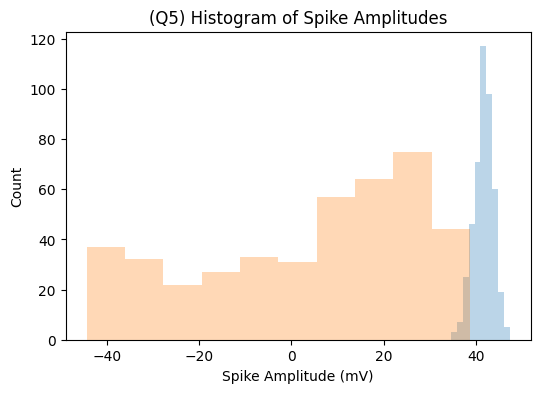

In [28]:
fig, ax = plt.subplots(1, figsize = (6, 4))

ax.set_title('(Q5) Histogram of Spike Amplitudes')

ax.hist(n_spikes['HH'], alpha = 0.3, label = 40)
ax.hist(n_spikes['DNN'], alpha = 0.3)

ax.set_ylabel('Count')
ax.set_xlabel('Spike Amplitude (mV)')

plt.show()

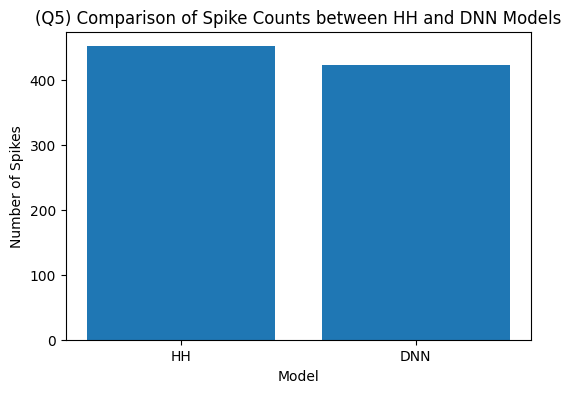

In [29]:
# Create histogram
plt.figure(figsize = (6, 4))
plt.bar(['HH', 'DNN'], [len(n_spikes['HH']), len(n_spikes['DNN'])])
plt.xlabel('Model')
plt.ylabel('Number of Spikes')
plt.title('(Q5) Comparison of Spike Counts between HH and DNN Models')
plt.show()

<div class="alert alert-success">
<span style="color:black">
    
**A5 conclusion** 

The DNN output does not align with the analytic HH model. Moreover, across 100 simulations, the HH overall produces a higher number of spikes compared to the HH model (last histogram). Examining multiple simulation plots reveals significant discrepancies between the DNN and HH models. In the HH model, the membrane potential exhibits a physiological integration and firing (with consistent spike amplitudes). Conversely, the DNN model demonstrates less physiological integration and behavior and spiking, where the spiking amplitudes are not consistent. This discrepancy likely arises from the fact that the DNN hasn't learnt the complex integration and firing dynamics of neurons, particularly in response to noisy input stimuli.

This can also be observed in the histogram of the spiking amplitudes, where it directly becomes clear that the DNN has a more spread histogram in contrary to the HH histogram which is much narrower (the reason for this is explained above). In this case, we found that across 100 trails, the HH model generated more spikes.

</span>

## Q6: Receptive field (RF)

Calculate the receptive field of the CNN model, as described in the attached paper Drakopoulos et al. (2021). You will need formula 4 and its context. You can find the parameters by exploring the model using model.summary() and layer.name, layer.output_shape, layer.\_\_class_\_.\_\_name\_\_ in model.get_layer('model_2').layers. The receptive field has to be higher than the adaptation time constant for the model to converge and for the architecture to be sufficiently complex to capture the adaptation time.

Don't forget to divide your answer by the sampling frequency to get the RF in ms. We can see in Q2 that this RF is sufficient. What would happen with RF, and visually, when only 2 layers were used?

In [30]:
model_layers = model.get_layer('model_2').layers
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bmm_input (InputLayer)      [(None, 2560, 1)]         0         
                                                                 
 model_2 (Functional)        (None, 2048, 1)           1511489   
                                                                 
Total params: 1511489 (5.77 MB)
Trainable params: 1511489 (5.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [31]:
# check the instances in a Conv2D object
# help(model_layers[2]) 

In [32]:
# get the encoder layers
encoder_layers = []
for layer in model_layers:
    if layer.__class__.__name__ == 'Conv2D':
        s = layer.strides
        k = layer.kernel_size
        encoder_layers.append((layer.name, k, s))

In [33]:
encoder_layers

[('conv2d_10', (16, 1), (2, 1)),
 ('conv2d_11', (16, 1), (2, 1)),
 ('conv2d_12', (16, 1), (2, 1)),
 ('conv2d_13', (16, 1), (2, 1)),
 ('conv2d_14', (16, 1), (2, 1)),
 ('conv2d_15', (16, 1), (2, 1)),
 ('conv2d_16', (16, 1), (2, 1)),
 ('conv2d_17', (16, 1), (2, 1)),
 ('conv2d_18', (16, 1), (2, 1))]

In [34]:
def get_RF(N, k, s, fs = 20):
    S = (1 - s**N)/(1 - s)
    return ((k - 1)*S + 1) / fs

In [35]:
N, k, s = len(encoder_layers), 16, 2
RF = get_RF(N, k, s)

print(f'The RF is: {RF:.2f} ms')

The RF is: 383.30 ms


<div class="alert alert-success">
<span style="color:black">
    
**A6 conclusion** 

In terms of visual interpretation, when only 2 layers are used in the CNN model, the RF size would likely be smaller compared to when more layers are utilized. This reduction in RF size may result in a limited ability of the model to capture long-term dependencies and complex adaptation dynamics (especially for larger inputs). This is indeed stated in Drakopoulos et al.; they state that using fewer layers is not able to fully transform step-like inputs to spike trains over the whole time window. Especially for larger currents that can generate a an infinte spike train. 

**Calculation $r_N$:** One can notice that the number of filter coeffecients $(\forall n \in \{1, 2, \ldots, N\})\ k_n=k\in\mathbb{R}$ and the straid lenght $(\forall i \in \{1, 2, \ldots, N-1\})\ s_i=s\in\mathbb{R}$. This yields
$$
r_N = \sum_{n=1}^N\left((k_n-1)\cdot \prod_{i=1}^{n-1}s_i\right) + 1 = 1 + (k-1) \sum_{n=1}^{N} s^{n} = 1 + (k+1)\cdot \frac{1-s^{N}}{1-s}.
$$
</span>